In [6]:
if torch.cuda.is_available():
    print('Графическое ускорение (GPU) доступно')
    device = torch.device('cuda')
    print(f'Используется устройство: {torch.cuda.get_device_name(0)}')
else:
    print('Графическое ускорение (GPU) недоступно')
    device = torch.device('cpu')

print(f'Используется устройство: {device}')

Графическое ускорение (GPU) доступно
Используется устройство: NVIDIA GeForce RTX 3070 Laptop GPU
Используется устройство: cuda


In [9]:
import torch
import torchvision.models as models
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import os

# Пути к тренировочным и тестовым данным
train_dir = r'C:\Users\Prince\Desktop\марго\дз5\archive\afhq\train'
test_dir = r'C:\Users\Prince\Desktop\марго\дз5\archive\afhq\val'
# Загрузка предобученной модели
model = models.resnet50(pretrained=True)

# Замораживание базовых слоев
for param in model.parameters():
    param.requires_grad = False

# Замена последнего полносвязанного слоя на новый для классификации на 3 класса
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)

# Задаем критерий потерь и оптимизатор (для fine-tuning)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Загрузка тренировочных данных
train_dataset = datasets.ImageFolder(train_dir, transform=transform)

# Делим тренировочные данные на тренировочные и валидационные (например, 80% и 20%)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Загрузка тестовых данных
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Обучение модели
num_epochs = 10 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)  # Отправляем модель на устройство

for epoch in range(num_epochs):
    model.train()
    # Тренировочный шаг
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Отправляем данные и метки на устройство
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Оценка модели на валидационных данных
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Отправляем данные и метки на устройство
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(val_loader)
    val_accuracy = correct / total

    print(f'Epoch {epoch+1}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Тестирование модели на тестовых данных
model.eval()
test_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Отправляем данные и метки на устройство
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_loss /= len(test_loader)
test_accuracy = correct / total

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


Epoch 1, Val Loss: 0.0288, Val Accuracy: 0.9925
Epoch 2, Val Loss: 0.0130, Val Accuracy: 0.9969
Epoch 3, Val Loss: 0.0139, Val Accuracy: 0.9966
Epoch 4, Val Loss: 0.0116, Val Accuracy: 0.9969
Epoch 5, Val Loss: 0.0097, Val Accuracy: 0.9973
Epoch 6, Val Loss: 0.0134, Val Accuracy: 0.9962
Epoch 7, Val Loss: 0.0093, Val Accuracy: 0.9976
Epoch 8, Val Loss: 0.0081, Val Accuracy: 0.9986
Epoch 9, Val Loss: 0.0098, Val Accuracy: 0.9976
Epoch 10, Val Loss: 0.0072, Val Accuracy: 0.9979
Test Loss: 0.0054, Test Accuracy: 0.9987


In [10]:
# Сохранение модели
model_path = 'resnet50_finetuned.pth'
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')


Model saved to resnet50_finetuned.pth


C:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


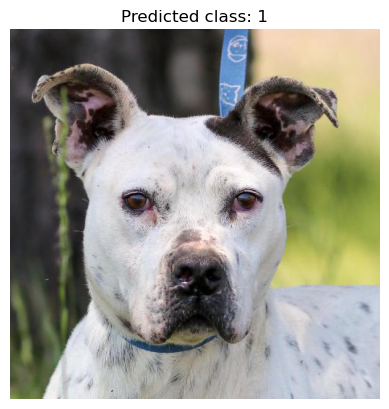

In [12]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import os

# Загрузка модели и обновление FC слоя
model = models.resnet50(pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)

# Загрузка сохраненных весов
model_path = 'resnet50_finetuned.pth'
model.load_state_dict(torch.load(model_path))
model.eval()  # Переключение модели в режим предсказания (оценки)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Загрузка изображения и выполнение предсказания
def predict_image(image_path, model, transform):
    image = Image.open(image_path).convert('RGB')  # Добавляем конвертацию, чтобы избежать проблем с альфа-каналом
    image_tensor = transform(image).unsqueeze(0)  # Добавляем batch dimension
    image_tensor = image_tensor.to(device)  # Отправляем изображение на устройство (GPU или CPU)
    
    model.to(device)
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
        
    return predicted.item(), image

image_path = r'C:\Users\Prince\Desktop\марго\дз5\archive\afhq\val\dog\flickr_dog_000104.jpg'
predicted_class, image = predict_image(image_path, model, transform)

# Отображение изображения и класса
plt.imshow(image)
plt.title(f'Predicted class: {predicted_class}')
plt.axis('off')  
plt.show()
